<a href="https://colab.research.google.com/github/AsherReedy/Monte-Carlo-iRisk-Lab-Meetings-and-Homework/blob/main/IRisk_Meeting01_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# IRisk — Meeting 1: Monte Carlo Mindset, Reproducibility, and Constants (π, e)

**Today**
- Understand what Monte Carlo (MC) estimates and why it works (LLN/CLT intuition).
- Make results reproducible in Colab (fixed seeds, controlled randomness).
- Implement two classic estimators:
  - π via hit-or-miss in the unit square (quarter-circle).
  - e via the “sum of Uniforms exceeds 1” experiment $\mathbb{E}[N]=e$.
- Visualize running means and 95% CIs; observe the $ n^{-1/2} $ error rate.



## 0) Colab & Reproducibility Setup

- Click File -> Save a copy in Drive to create a copy that allow cell edits
- This notebook is designed to run top-to-bottom.
- We use `numpy.random.default_rng` and a single seed for reproducibility.




## 1) Imports & Global Parameters
- Single place to set the random seed and simulation sizes.


In [ ]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
SEED = 843 #change to your favorite number
rng = np.random.default_rng(SEED)

# Simulation sizes
N_POINTS_LIST = [10**k for k in range(2, 6)]   # 1e2, 1e3, 1e4, 1e5
N_TRIALS_LIST = [10**k for k in range(2, 6)]   # for the e-experiment

# Plot defaults
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True



## 2) Utility: Confidence Intervals
We'll use a normal-approximation CI when $n$ is reasonably large:
$ \bar{X} \pm z_{0.975} \cdot s/\sqrt{n} $


In [ ]:
def mean_ci_95(samples):
    samples = np.asarray(samples, dtype=float)
    n = samples.size
    mean = samples.mean()
    sd = samples.std(ddof=1) if n > 1 else 0.0
    z = 1.959963984540054  # approx. for 97.5th percentile
    half = z * sd / math.sqrt(max(n, 1))
    return mean, (mean - half, mean + half), sd



## 3) Estimating π via Hit-or-Miss

We sample points uniformly in the unit square $[0,1]\times[0,1]$. The quarter-circle of radius 1 has area \\(\\\pi/4\\).  
If \\(K\\) out of \\(n\\) points fall inside the quarter-circle, then
$\hat{\pi} = 4 \cdot \frac{K}{n} $



In [ ]:
def estimate_pi_hit_or_miss(n, rng):
    # Vectorized sampling in [0,1]^2
    x = rng.random(n)
    y = rng.random(n)
    inside = (x*x + y*y) <= 1.0
    p_hat = inside.mean()
    pi_hat = 4.0 * p_hat
    return pi_hat, inside.sum()



### 3a) Running Means & 95% CI for π
Observe convergence and CI width as $n$ grows.


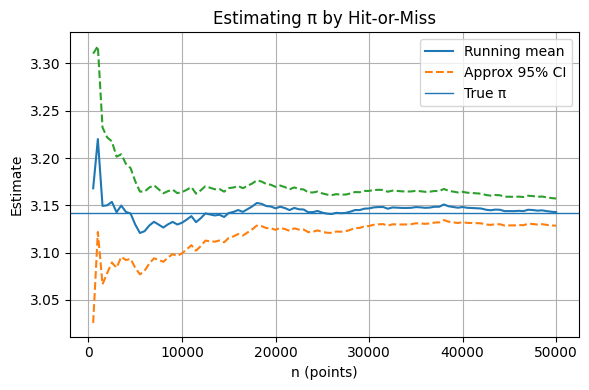

In [ ]:
def running_pi_estimates(n_total, rng):
    # Do it in chunks to visualize running means
    chunk = max(100, n_total // 100)  # ~100 updates
    xs = []
    running_means = []
    counts_in = 0
    drawn = 0
    while drawn < n_total:
        m = min(chunk, n_total - drawn)
        x = rng.random(m)
        y = rng.random(m)
        inside = (x*x + y*y) <= 1.0
        counts_in += inside.sum()
        drawn += m
        pi_hat = 4.0 * (counts_in / drawn)
        xs.append(drawn)
        running_means.append(pi_hat)
    return np.array(xs), np.array(running_means)

n_total = 50_000
xs, running_means = running_pi_estimates(n_total, np.random.default_rng(SEED))
true_pi = math.pi

# Compute CI on the fly using a simple variance proxy for indicator
# Var(4*I) = 16*p*(1-p), estimate p by running count/drawn.
# We'll compute a simple band at each point.
upper = []
lower = []
z = 1.959963984540054
counts_in = 0
drawn = 0
rng2 = np.random.default_rng(SEED)
for m in np.diff(np.append([0], xs)):
    x = rng2.random(m)
    y = rng2.random(m)
    inside = (x*x + y*y) <= 1.0
    counts_in += inside.sum()
    drawn += m
    p_hat = counts_in / drawn
    var_pi_hat = 16.0 * p_hat * (1 - p_hat) / max(drawn, 1)
    sd_pi_hat = math.sqrt(max(var_pi_hat, 0.0))
    upper.append((4.0 * p_hat) + z * sd_pi_hat)
    lower.append((4.0 * p_hat) - z * sd_pi_hat)

plt.figure()
plt.plot(xs, running_means, label="Running mean")
plt.plot(xs, lower, linestyle="--", label="Approx 95% CI")
plt.plot(xs, upper, linestyle="--")
plt.axhline(true_pi, linewidth=1, label="True π")
plt.xlabel("n (points)")
plt.ylabel("Estimate")
plt.title("Estimating π by Hit-or-Miss")
plt.legend()
plt.tight_layout()
plt.show()



### 3b) CI Coverage for π (Fixed $n$)
How often does a nominal 95% CI include the true value? We try multiple independent runs at a fixed $n$.


In [ ]:
def pi_coverage(n, n_runs, rng):
    hits = 0
    for _ in range(n_runs):
        pi_hat, k = estimate_pi_hit_or_miss(n, rng)
        # Approximate variance using indicator variance with p ≈ pi/4
        p = math.pi / 4.0
        var_pi_hat = 16.0 * p * (1 - p) / n
        se = math.sqrt(var_pi_hat)
        z = 1.959963984540054
        lo, hi = pi_hat - z*se, pi_hat + z*se
        if lo <= math.pi <= hi:
            hits += 1
    return hits / n_runs

coverage = pi_coverage(n=10_000, n_runs=200, rng=np.random.default_rng(SEED+1))
print("Approximate 95% CI empirical coverage at n=10,000:", round(coverage, 3))


Approximate 95% CI empirical coverage at n=10,000: 0.935



## 4) Estimating $e$ via the “Sum of Uniforms Exceeds 1” Experiment

Let $U_1, U_2, \ldots$ be i.i.d. Uniform(0,1). Define $N$ as the number of uniforms required so that the running sum first exceeds 1.  
A classical result: $ \mathbb{E}[N] = e $. So the sample average of many i.i.d. copies of $N$ estimates $e$.


In [ ]:
def trial_count_to_exceed_one(rng):
    total = 0.0
    count = 0
    while total <= 1.0:
        total += rng.random()
        count += 1
    return count

def estimate_e(n_trials, rng):
    counts = np.fromiter((trial_count_to_exceed_one(rng) for _ in range(n_trials)), dtype=float, count=n_trials)
    mean, ci, sd = mean_ci_95(counts)
    return mean, ci, sd, counts

for ntrials in [10**2, 10**3, 10**4]:
    mean, ci, sd, _ = estimate_e(ntrials, np.random.default_rng(SEED))
    print(f"n_trials={ntrials:>6}  e_hat={mean:.6f}  CI95=({ci[0]:.6f}, {ci[1]:.6f})  sd={sd:.4f}")


n_trials=   100  e_hat=2.700000  CI95=(2.524917, 2.875083)  sd=0.8933
n_trials=  1000  e_hat=2.750000  CI95=(2.694484, 2.805516)  sd=0.8957
n_trials= 10000  e_hat=2.729900  CI95=(2.712683, 2.747117)  sd=0.8784



### 4a) Running Means & 95% CI for $e$


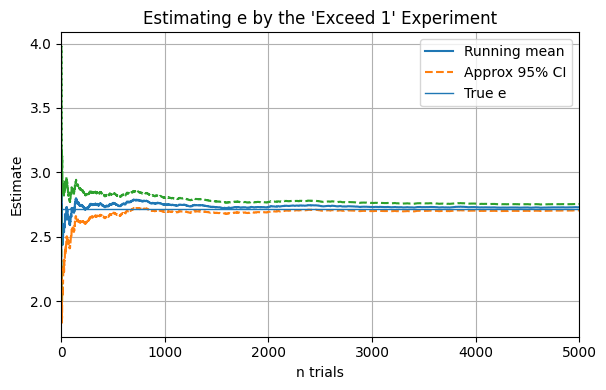

In [ ]:
def running_e_estimates(n_trials, rng):
    counts = []
    running_means = []
    xs = []
    for i in range(1, n_trials+1):
        counts.append(trial_count_to_exceed_one(rng))
        xs.append(i)
        running_means.append(np.mean(counts))
    return np.array(xs), np.array(running_means)

n_trials = 10_000
xs_e, running_e = running_e_estimates(n_trials, np.random.default_rng(SEED))

# Compute simple normal CI for the running mean (using running sd)
running_sd = []
acc = []
for c in np.fromiter((trial_count_to_exceed_one(np.random.default_rng(SEED+i)) for i in range(n_trials)), dtype=float, count=n_trials):
    acc.append(c)
    running_sd.append(np.std(acc, ddof=1) if len(acc) > 1 else 0.0)
running_sd = np.array(running_sd)

z = 1.959963984540054
se = np.divide(running_sd, np.sqrt(np.maximum(xs_e, 1)), where=(xs_e>0))
lower_e = running_e - z*se
upper_e = running_e + z*se

plt.figure()
plt.plot(xs_e, running_e, label="Running mean")
plt.plot(xs_e, lower_e, linestyle="--", label="Approx 95% CI")
plt.plot(xs_e, upper_e, linestyle="--")
plt.axhline(math.e, linewidth=1, label="True e")
plt.xlabel("n trials")
plt.ylabel("Estimate")
plt.title("Estimating e by the 'Exceed 1' Experiment")
plt.legend()
plt.tight_layout()
plt.xlim(0, 5000) #try 100 and 1000
plt.show()



## 5) Error vs Sample Size (log–log)
We expect the root-n error rate: absolute error $|\hat\theta - \theta|$ should scale like $ n^{-1/2} $.


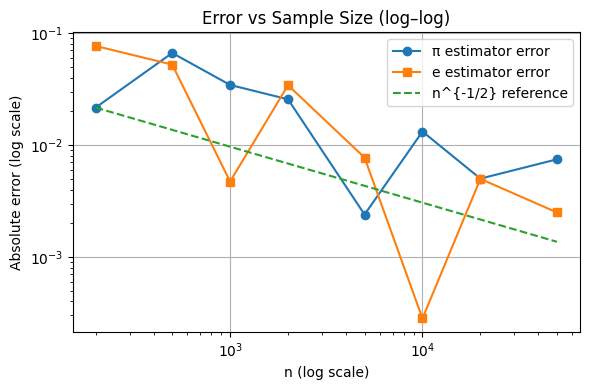

In [ ]:
def abs_error_pi(n, rng):
    est, _ = estimate_pi_hit_or_miss(n, rng)
    return abs(est - math.pi)

def abs_error_e(n_trials, rng):
    mean, _, _, _ = estimate_e(n_trials, rng)
    return abs(mean - math.e)

ns = np.array([200, 500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000])
errors_pi = [abs_error_pi(int(n), np.random.default_rng(SEED + i)) for i, n in enumerate(ns)]
errors_e  = [abs_error_e(int(n), np.random.default_rng(SEED + 100 + i)) for i, n in enumerate(ns)]

plt.figure()
plt.loglog(ns, errors_pi, marker="o", label="π estimator error")
plt.loglog(ns, errors_e, marker="s", label="e estimator error")
# Reference slope line ~ n^{-1/2}: choose two points to draw a guideline
ref_x = np.array([ns[0], ns[-1]])
ref_y = errors_pi[0] * (ref_x / ref_x[0])**(-0.5)
plt.loglog(ref_x, ref_y, linestyle="--", label="n^{-1/2} reference")
plt.xlabel("n (log scale)")
plt.ylabel("Absolute error (log scale)")
plt.title("Error vs Sample Size (log–log)")
plt.legend()
plt.tight_layout()
plt.show()



## 6) Checklist & Next Steps

**During meeting (we did):**
- Ran π and e estimators; verified running means and approximate confidence intervals.
- Observed $ n^{-1/2} $ error rate on log–log plot.

**Homework:**
Due 9/12 by 11:59PM by email: erici2@illinois.edu


# Homework

Due 9/12 by 11:59PM via email: erici2@illinois.edu

1. Document how you would edit the code above in order to estimate the volume of a unit sphere, then create the simulation.

**Explanation:**
I used a method similar to the one used in the pi simulation, where I imagined the unit sphere inscribed in a cube. Then I took random samples of points inside of the cube and kept track of points that are also inside the sphere. After the simulation, I found the ratio of points inside the sphere to those outside the sphere and multiplied it by the cube's volume to find the approximate area that the sphere took up.

In [ ]:

def estimate_sphere_volume(n, rng):
    Cube_Volume = 8
    x = rng.random(n)
    y = rng.random(n)
    z = rng.random(n)

    inside = (x**2 + y**2 + z**2) <= 1
    v_hat = inside.mean()
    return v_hat * Cube_Volume

print(estimate_sphere_volume(100_000,rng))


4.17608


2. Choose another example that uses repeated random draws to estimate a solution. Report any interesting results.

**Explanation:**
My example calculates the integral of a function. The formula uses the integral average value formula (1/(b-a))*integral = E(x), you can rearrange this to solve for the integral and approximate E(x) with simulations.

In [ ]:
def function(x):
  f = (math.e)**(-x**2)
  f2 = np.sin(x)
  return f

a = 0
b = 100
n = 30000
x_sample = np.zeros(n)

for i in range(len(x_sample)):
  x_sample[i] = np.random.uniform(a,b)

total = 0
for i in range(len(x_sample)):
  total = total + function(x_sample[i])

result = (total / n) * (b - a)
print(result)


0.967243188259781


3. Write an algorithm that will output a "random" arrangement of the numbers 1 through 8 as a psuedorandom number generator. It should

*   be deterministic for a given seed
*   produce a unique arrangement for every possible seed

**Explanation:**



In [ ]:

def custom_rng(seed):
  seed = (int(seed * 1664525) + 12345678) % 2**32

  snum = str(seed)
  snum = snum.replace("9","")
  snum = snum.replace("0","")

  return int(snum)
  pass

def test():
  l = []
  for i in range(100):
    l.append(custom_rng(np.random.uniform(1,9999)))
  return l

print(test())


[165341541, 215351, 18152642, 3134753, 137718475, 2254466373, 3526533251, 6287712, 314451477, 1867554383, 3242371, 22811675, 258682612, 1223332, 178131461, 3171366854, 1114834, 84584483, 31421648, 382263716, 26752382, 88713625, 47515243, 321817188, 345727556, 23143112, 2717447, 2763425, 2847658, 18866562, 385416247, 84647, 16437545, 185716, 72127826, 5262, 37158336, 24238821, 12271417, 26778866, 376463387, 16138758, 8338442, 14354533, 1366668, 267836468, 4272776, 3637674645, 57215114, 4476641, 26872874, 15168536, 37167716, 4888147, 156586534, 2281664775, 22174336, 7214436, 15452564, 423777476, 416418, 362131, 22636373, 27822868, 364358341, 846261778, 2578673, 36837322, 358748568, 4347427, 268315, 33871468, 3453313872, 472272, 2826771, 34266481, 325435464, 36121883, 21328426, 364246742, 52748158, 3634826, 2547231, 218173822, 46541817, 24254261, 1176741742, 375876558, 231765, 257365, 263718768, 2787517, 21647532, 1126623, 1683114552, 24212224, 34758685, 37787423, 1577666, 785223]


4. Explain the law of large numbers and central limit theorem in your own words. Why are these theorems important for Monte Carlo simulation?

**Explanation:**

The law of large numbers says that if you repeatedly take samples from a population and average the results, the results will approach the true expected value for the population as the number of samples increases.

The central limit theorem says that if you take many samples and average the results, the averages from the samples will follow a normal distribution.

The law of large numbers is important for Monte Carlo simulation because the simulation process involves running many independent, random simulations and using the collected information to come to conclusions about the population. The more simulations we run, the more accurate our conclusions will be.

The central limit theorem is important because no matter the distribution of the population, we know that the average of the samples will be normaly distributed. The assumption of normalcy allows us to determine the accuracy of the simulation by calculating confidence intervals indicating that the true value is within the interval